<a href="https://colab.research.google.com/github/bori00/BreastCancerSegmentation/blob/main/Breast_Cancer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Background

* Dataset: https://github.com/PathologyDataScience/BCSS
* Paper: https://academic.oup.com/bioinformatics/article/35/18/3461/5307750

## Progress since week 1

*  implemented data loading from disk, with correct mapping of images and masks -> enables training of full dataset (https://github.com/tensorflow/tensorflow/issues/49514)
*  added class weighting (https://www.tensorflow.org/tutorials/images/segmentation#optional_imbalanced_classes_and_class_weights)
*  overwrote model visualization, to show layers of custom model
*  fixed bug in unet: replaced UpSample2d by Conv2dTranspose

## TODO



*   dat augmentation
*   train on the full dataset
*   reset batch size to 32 or similar
*   try Fully Convolutional Networks

## Questions

*  image distortions -> UNet requires fixed size

# Setup: Importing the libraries and the dataset

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import urllib
from urllib import request

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import pandas as pd
import numpy as np

import cv2
import os

from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

In [2]:
# mount google drive on the virtual machine created by colab
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
TEST_RATIO = 0.2
SEED = 123
IMG_HEIGHT = 512
IMG_WIDTH = 512
BATCH_SIZE = 2
MAX_DATASET_SIZE = 152

## Load Images. Initial Dataset Construction

## Mount and unzip images from drive

In [4]:
IMAGES_DIRECTORY = '/content/rgbs_colorNormalized';
MASKS_DIRECTORY = '/content/masks'

In [ ]:
!unzip gdrive/MyDrive/PRS_Project/masks-20221122T203004Z-001.zip 
!unzip gdrive/MyDrive/PRS_Project/rgbs_colorNormalized-20221122T211021Z-001.zip
!unzip gdrive/MyDrive/PRS_Project/rgbs_colorNormalized-20221122T211021Z-002.zip
!unzip gdrive/MyDrive/PRS_Project/rgbs_colorNormalized-20221122T211021Z-003.zip

## Build datasets

In [181]:
# setting dictionary for the tf_data_dataset parameters
tf_Dataset_args=dict(labels=None,
                     label_mode=None,
                     validation_split=TEST_RATIO,
                     batch_size=BATCH_SIZE,
                     image_size=(IMG_HEIGHT, IMG_WIDTH),
                     seed=SEED,
                     crop_to_aspect_ratio=False, #DO NOT KEEP THE ASPECT RATIO OF THE IMAGES. This results in the distortion of the images and possible errors. U-Nets require fixed sized images
                     shuffle=False #IMPOARTANT FOR PRSERVING THE IMAGE + MASK pair
                     )

In [182]:
train_images_ds = tf.keras.utils.image_dataset_from_directory(
  IMAGES_DIRECTORY,
  **tf_Dataset_args,
  subset="training",
  color_mode='rgb')

test_images_ds = tf.keras.utils.image_dataset_from_directory(
  IMAGES_DIRECTORY,
  **tf_Dataset_args,
  subset="validation",
  color_mode='rgb')

Found 151 files belonging to 1 classes.
Using 121 files for training.
Found 151 files belonging to 1 classes.
Using 30 files for validation.


In [183]:
train_masks_ds = tf.keras.utils.image_dataset_from_directory(
  MASKS_DIRECTORY,
   **tf_Dataset_args,
  subset="training",
  color_mode='grayscale')

test_masks_ds = tf.keras.utils.image_dataset_from_directory(
   MASKS_DIRECTORY,
   **tf_Dataset_args,
  subset="validation",
  color_mode='grayscale')

Found 151 files belonging to 1 classes.
Using 121 files for training.
Found 151 files belonging to 1 classes.
Using 30 files for validation.


In [184]:
train_ds = tf.data.Dataset.zip((train_images_ds, train_masks_ds))
test_ds = tf.data.Dataset.zip((test_images_ds, test_masks_ds))

In [185]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Loading the Class Definitions

In [186]:
classes_df = pd.read_csv("gdrive/MyDrive/PRS_Project/gtruth_codes.csv")
classes_df

label   GT_code
0               outside_roi         0
1                     tumor         1
2                    stroma         2
3    lymphocytic_infiltrate         3
4        necrosis_or_debris         4
5      glandular_secretions         5
6                     blood         6
7                   exclude         7
8            metaplasia_NOS         8
9                       fat         9
10             plasma_cells        10
11  other_immune_infiltrate        11
12          mucoid_material        12
13    normal_acinus_or_duct        13
14               lymphatics        14
15             undetermined        15
16                    nerve        16
17              skin_adnexa        17
18             blood_vessel        18
19            angioinvasion        19
20                     dcis        20
21                    other        21

In [187]:
nr_classes = len(classes_df)

**Important**: The "outside_roi" class is "don't case", not "others", and should be assigned weight 0 in the model.

# Exploratory Data Analysis

## From the images in the drive folders

In [188]:
def plot_image_and_mask(image_name):
  plt.figure(figsize=(20, 8))
  plt.suptitle("Image: " + image_name)

  plt.subplot(1, 2, 1)
  mask = mpimg.imread(MASKS_DIRECTORY + image_name)
  plt.imshow(mask)
  plt.title("Mask")
  
  plt.subplot(1, 2, 2)
  image = mpimg.imread(IMAGES_DIRECTORY + image_name)
  plt.imshow(image)
  plt.title("Image")

  plt.show()

  print("Image shape", image.shape, "Mask shape: ", mask.shape)

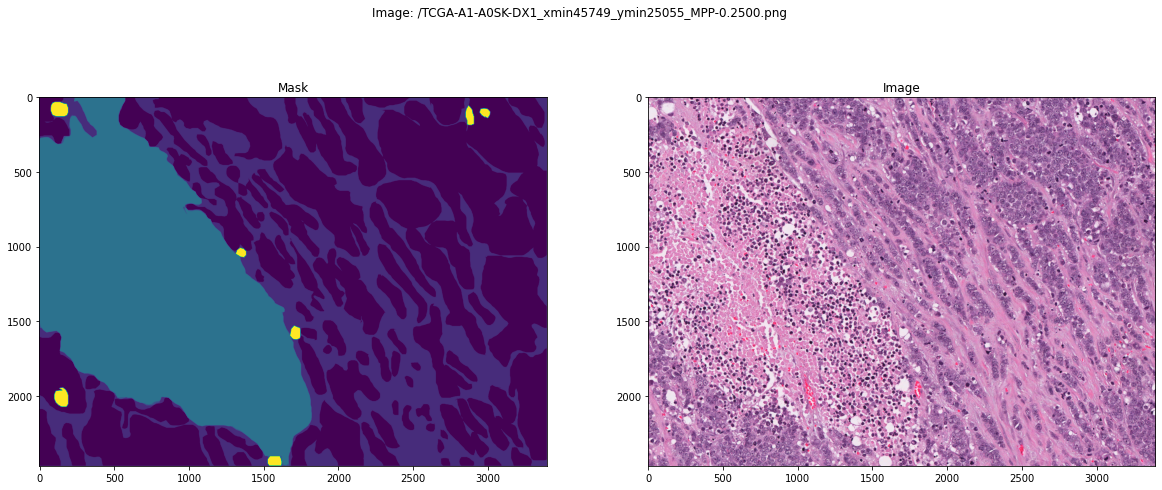

Image shape (2467, 3394, 3) Mask shape:  (2467, 3394)


In [189]:
plot_image_and_mask('/TCGA-A1-A0SK-DX1_xmin45749_ymin25055_MPP-0.2500.png')

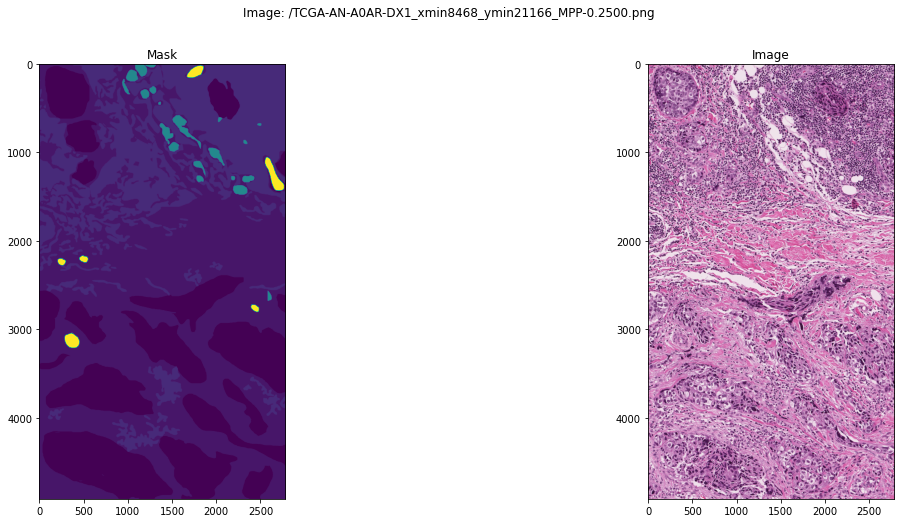

Image shape (4917, 2782, 3) Mask shape:  (4917, 2782)


In [190]:
plot_image_and_mask('/TCGA-AN-A0AR-DX1_xmin8468_ymin21166_MPP-0.2500.png')

## From the Dataset

In [191]:
def display(display_list):
  # source: https://www.tensorflow.org/tutorials/images/segmentation
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i].numpy().astype("uint8")))
    plt.axis('off')
  plt.show()

In [192]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(100, 200, crop_to_aspect_ratio=True),
])

Sample Batch in the Training Dataset
Image shape:  (512, 512, 3) Mask shape:  (512, 512, 1) Resized shape:  (100, 200, 3)


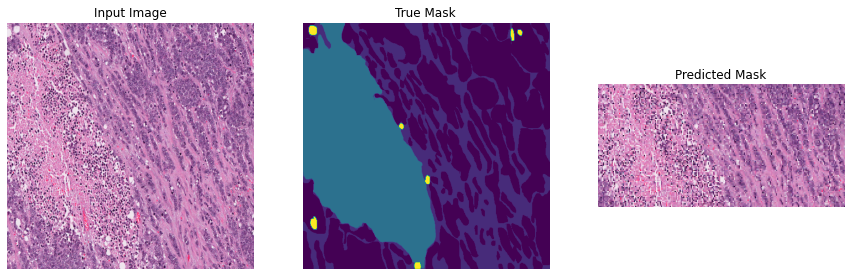

Image shape:  (512, 512, 3) Mask shape:  (512, 512, 1) Resized shape:  (100, 200, 3)


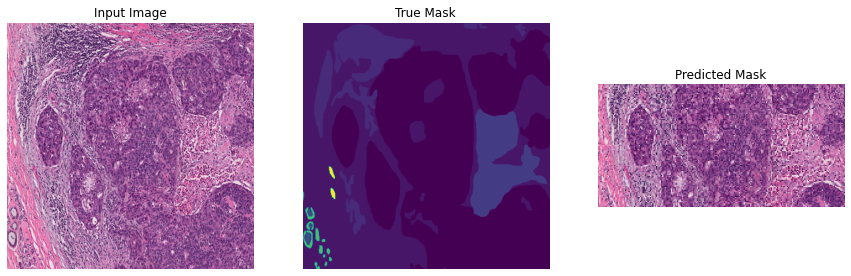

In [193]:
print("Sample Batch in the Training Dataset")

for images, masks in train_ds.take(1):
  for i in range(images.shape[0]):
    sample_image = images[i]
    sample_mask = masks[i]
    resized_image = resize_and_rescale(sample_image)
    print("Image shape: ", sample_image.shape, "Mask shape: ", sample_mask.shape, "Resized shape: ", resized_image.shape)
    display([sample_image, sample_mask, resized_image])
    resized_image = resize_and_rescale(sample_image)

# Class Weighting

**Important**: The "outside_roi" class is "don't case", not "others", and should be assigned weight 0 in the model. This weighting is achieved here.

In [194]:
def get_weights(mask):
  return (1 - tf.cast((mask==0), tf.int32)) / nr_classes # weight 1/nr_classes for all classes, except class 0, which has weight 0

In [195]:
def add_sample_weights(image, mask):
  return image, mask, get_weights(mask)

In [196]:
train_ds.map(add_sample_weights).element_spec

(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 512, 512, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 512, 512, 1), dtype=tf.float64, name=None))

# Initial Model: U-NET

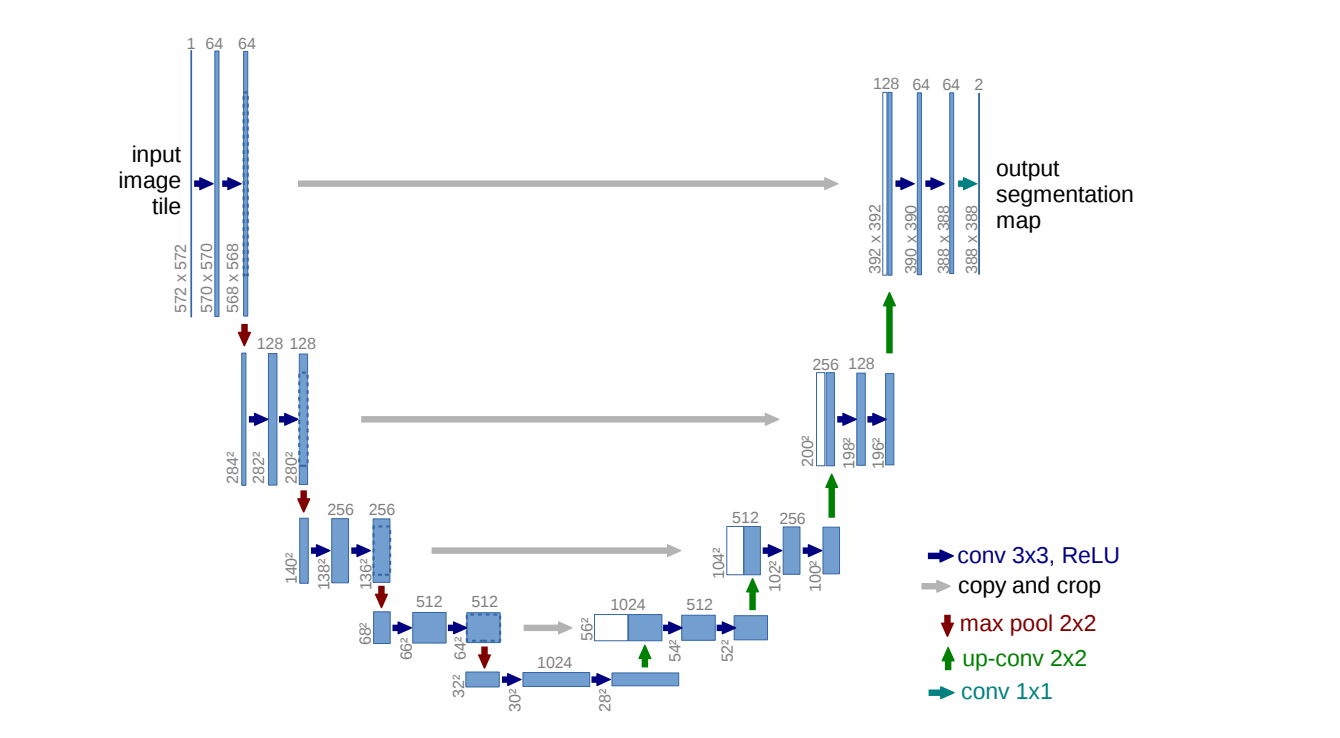

In [37]:
class UNetDoubleConvBlock(tf.keras.layers.Layer):
  def __init__(self, nr_channels):
    super(UNetDoubleConvBlock, self).__init__()
    self.nr_channels = nr_channels
    self.conv1 = layers.Conv2D(self.nr_channels, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")
    self.conv2 = layers.Conv2D(self.nr_channels, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")

  def get_config(self):
    config = super().get_config().copy()
    config.update({
        'doublceConv_nrChannels': self.nr_channels
    })
    return config

  def call(self, input):
    x = self.conv1(input)
    x = self.conv2(x)
    return x

In [38]:
class UNetEncoderBlock(tf.keras.layers.Layer):
  def __init__(self, nr_channels):
    super(UNetEncoderBlock, self).__init__()
    self.nr_channels = nr_channels
    self.double_conv_block = UNetDoubleConvBlock(nr_channels)
    self.max_pool = layers.MaxPool2D(2)

  def get_config(self):
    config = super().get_config().copy()
    config.update({
        'UNetEncoderBlock_nrChannels': self.nr_channels
    })
    return config

  def call(self, input):
    f = self.double_conv_block(input)
    p = self.max_pool(f)
    return f, p

In [216]:
class UNetDecoderBlock(tf.keras.layers.Layer):
  def __init__(self, nr_channels):
    super(UNetDecoderBlock, self).__init__()
    self.nr_channels = nr_channels
    self.upsample = layers.Conv2DTranspose(nr_channels, kernel_size=(2, 2), strides=(2, 2))
    self.max_pool = layers.MaxPool2D(2)
    self.double_conv_block = UNetDoubleConvBlock(nr_channels)

  def get_config(self):
    config = super().get_config().copy()
    config.update({
        'UNetDecoderBlock_nrChannels': self.nr_channels
    })
    return config

  def call(self, input):
    up_input, forward_input = input
    up_input = self.upsample(up_input)
    # crop
    crop = int((forward_input.shape[1] - up_input.shape[1]) / 2)
    forward_input = layers.Cropping2D(cropping=crop)(forward_input)
    x = layers.concatenate([up_input, forward_input])
    x = self.double_conv_block(x)
    return x

In [217]:
class MyUNetModel(tf.keras.Model):

  def __init__(self, nr_classes):
    super(MyUNetModel, self).__init__()
    self.encoder1 = UNetEncoderBlock(64)
    self.encoder2 = UNetEncoderBlock(128)
    self.encoder3 = UNetEncoderBlock(256)
    self.encoder4 = UNetEncoderBlock(512)
    self.bottleneck = UNetDoubleConvBlock(1024)
    self.decoder1 = UNetDecoderBlock(512)
    self.decoder2 = UNetDecoderBlock(256)
    self.decoder3 = UNetDecoderBlock(128)
    self.decoder4 = UNetDecoderBlock(64)
    self.final_conv = layers.Conv2D(nr_classes, 1, padding="same", activation = "softmax")


  def call(self, inputs, training=False):
    f1, p1 = self.encoder1(inputs)
    f2, p2 = self.encoder2(p1)
    f3, p3 = self.encoder3(p2)
    f4, p4 = self.encoder4(p3)
    p5 = self.bottleneck(p4)
    d1 = self.decoder1([p5, f4])
    d2 = self.decoder2([d1, f3])
    d3 = self.decoder3([d2, f2])
    d4 = self.decoder4([d3, f1])

    output = self.final_conv(d4)

    return output

  def model(self, input_shape):
    x = tf.keras.layers.Input(input_shape)
    return tf.keras.Model(inputs=[x], outputs=self.call(x))

In [218]:
unet_model = MyUNetModel(nr_classes)

In [219]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="sparse_categorical_crossentropy",
                  metrics="accuracy",
                  run_eagerly=True)

for image, mask in train_ds.take(1):
  input_shape = image[0].shape
full_input_shape = (None, input_shape[0], input_shape[1], input_shape[2])

unet_model.build(full_input_shape)

In [220]:
unet_model.model(input_shape).summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 u_net_encoder_block_24 (UNetEn  ((None, 512, 512, 6  38720      ['input_7[0][0]']                
 coderBlock)                    4),                                                               
                                 (None, 256, 256, 6                                               
                                4))                                                               
                                                                                            

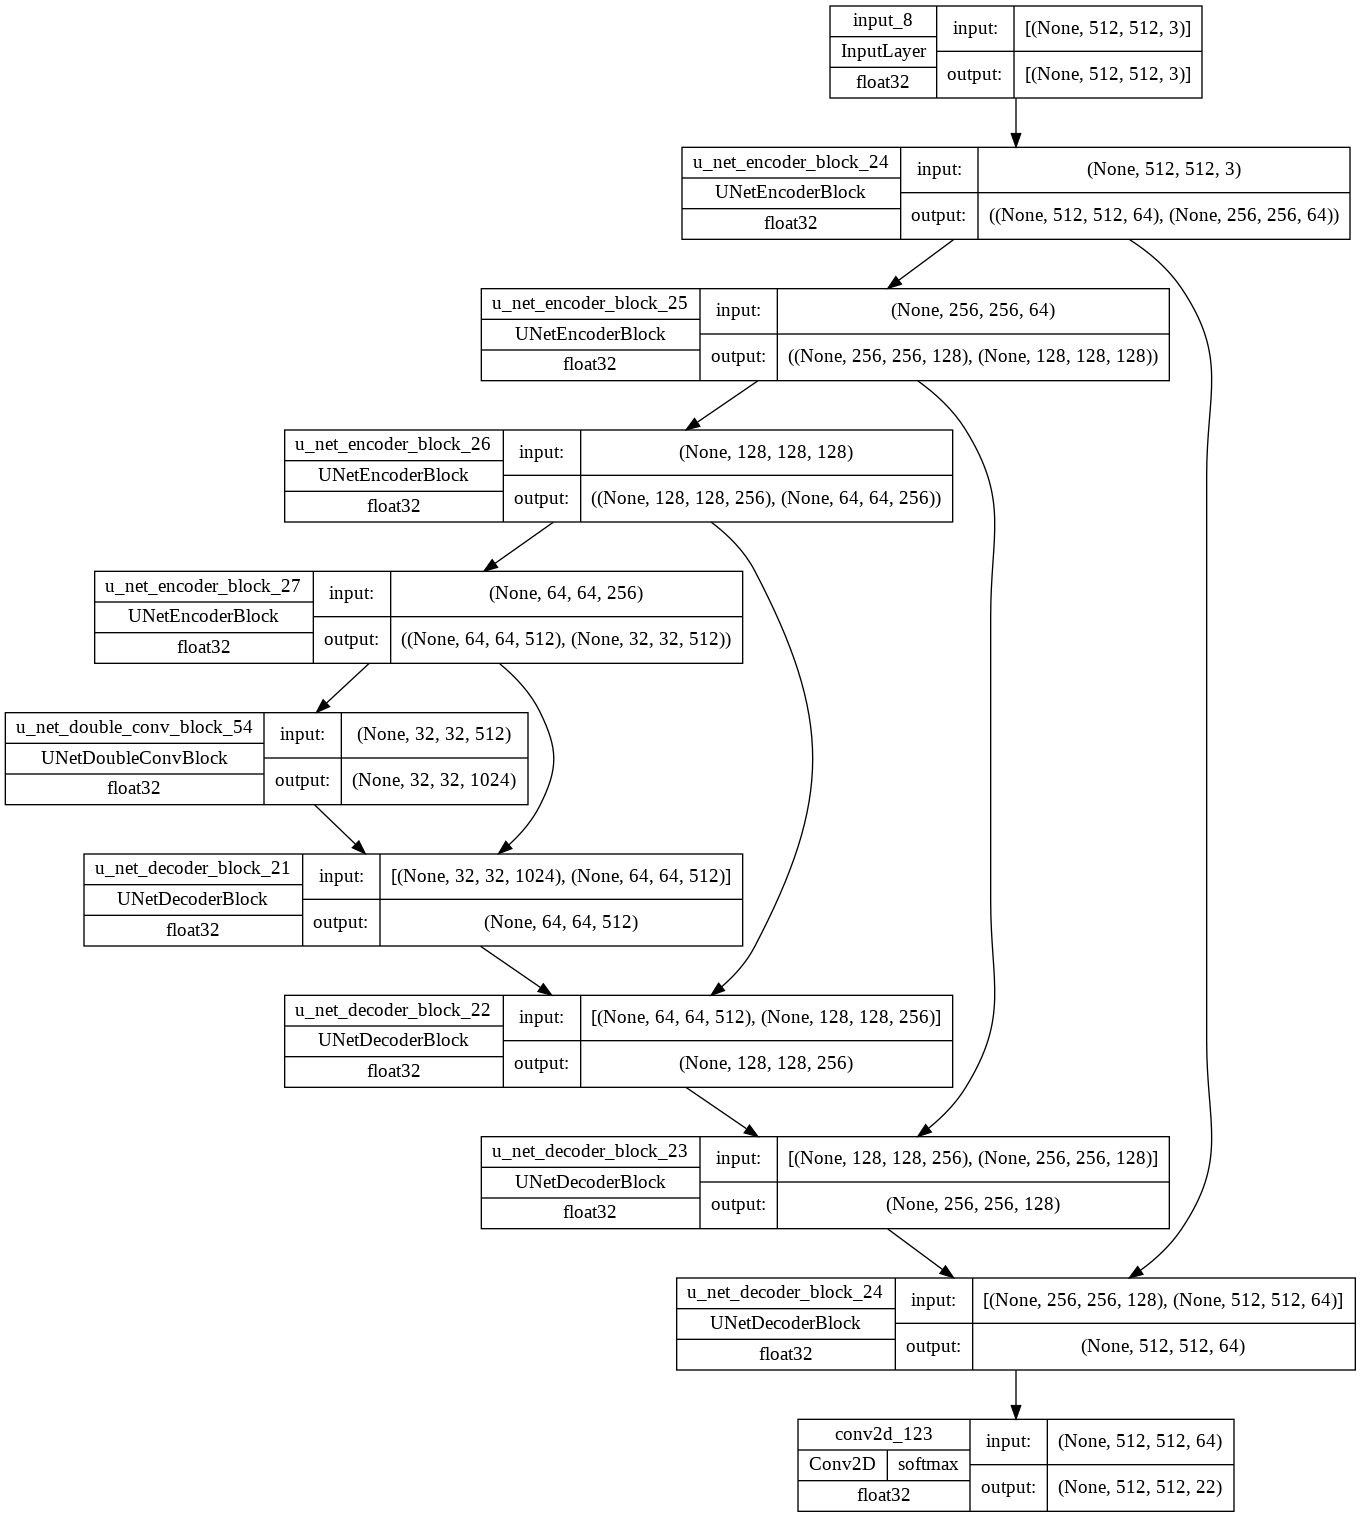

In [221]:
tf.keras.utils.plot_model(unet_model.model(input_shape), show_layer_activations=True, show_dtype=True, 
                       show_layer_names=True, show_shapes=True)

In [222]:
train_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 512, 512, 1), dtype=tf.float32, name=None))>

In [223]:
checkpoint_path = "gdrive/MyDrive/PRS_Project/checkpoints/unet/cp-{epoch:04d}.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    # save_best_only = True,
    save_freq=len(train_ds))

In [224]:
NUM_EPOCHS = 30

STEPS_PER_EPOCH = len(train_ds)
VALIDATION_STEPS = len(test_ds)

unet_model.save_weights(checkpoint_path.format(epoch=0))

model_history = unet_model.fit(train_ds.map(add_sample_weights),
                              epochs=NUM_EPOCHS,
                              steps_per_epoch=STEPS_PER_EPOCH,
                              callbacks=[cp_callback],
                              validation_data=test_ds,
                              batch_size = BATCH_SIZE)

Epoch 1/30
60/61 [============================>.] - ETA: 0s - loss: 3.0101 - accuracy: 0.2921
Epoch 1: saving model to gdrive/MyDrive/PRS_Project/checkpoints/unet/cp-0001.ckpt
61/61 [==============================] - 49s 692ms/step - loss: 2.9861 - accuracy: 0.2911 - val_loss: 6.1076 - val_accuracy: 0.2602
Epoch 2/30
60/61 [============================>.] - ETA: 0s - loss: 0.0936 - accuracy: 0.3452
Epoch 2: saving model to gdrive/MyDrive/PRS_Project/checkpoints/unet/cp-0002.ckpt
61/61 [==============================] - 38s 627ms/step - loss: 0.0932 - accuracy: 0.3446 - val_loss: 4.3859 - val_accuracy: 0.3551
Epoch 3/30
60/61 [============================>.] - ETA: 0s - loss: 0.0727 - accuracy: 0.3884
Epoch 3: saving model to gdrive/MyDrive/PRS_Project/checkpoints/unet/cp-0003.ckpt
61/61 [==============================] - 38s 626ms/step - loss: 0.0725 - accuracy: 0.3875 - val_loss: 4.0913 - val_accuracy: 0.3625
Epoch 4/30
60/61 [============================>.] - ETA: 0s - loss: 0.0664 -

In [226]:
unet_model.save_weights('./models/unet1')

In [231]:
def plot_loss_accuracy_history(history):
  plt.figure(figsize=(16, 8))

  plt.subplot(1, 2, 1)
  plt.plot(pd.DataFrame(history.history['accuracy']))
  plt.plot(pd.DataFrame(history.history['val_accuracy']))
  plt.grid(True)
  plt.title("Accuracy")
  plt.gca().legend(('training accuracy', 'validation accuracy'))

  plt.subplot(1, 2, 2)
  plt.plot(pd.DataFrame(history.history['loss']))
  plt.plot(pd.DataFrame(history.history['val_loss']))
  plt.grid(True)
  plt.title("Loss")
  plt.gca().legend(('training loss', 'validation loss'))
  plt.show()

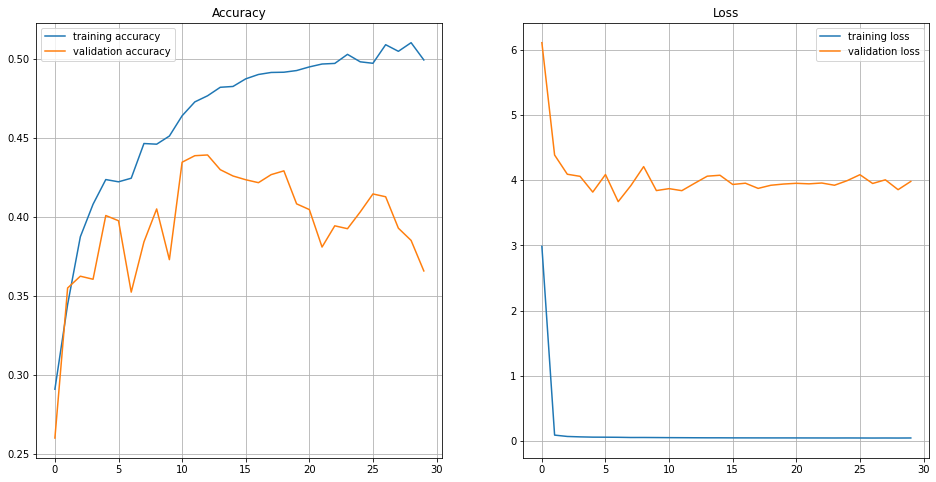

In [232]:
plot_loss_accuracy_history(model_history)

# Predict

Relied on: https://www.tensorflow.org/tutorials/images/segmentation#train_the_model

In [227]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [228]:
def show_predictions(model, dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 0s 118ms/step


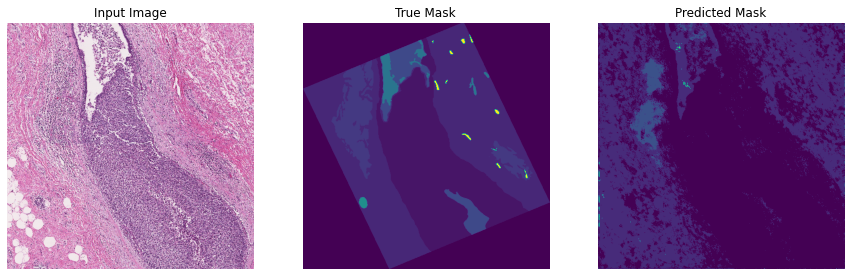

1/1 [==============================] - 0s 85ms/step


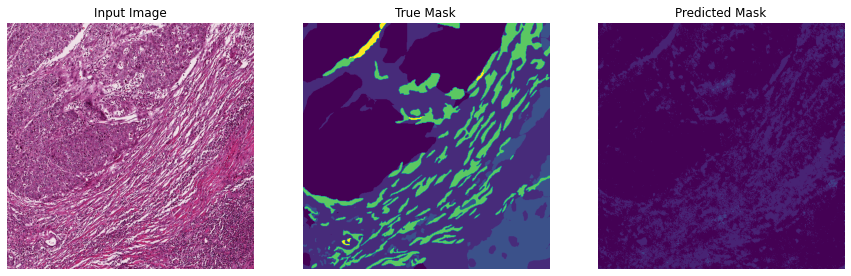

1/1 [==============================] - 0s 75ms/step


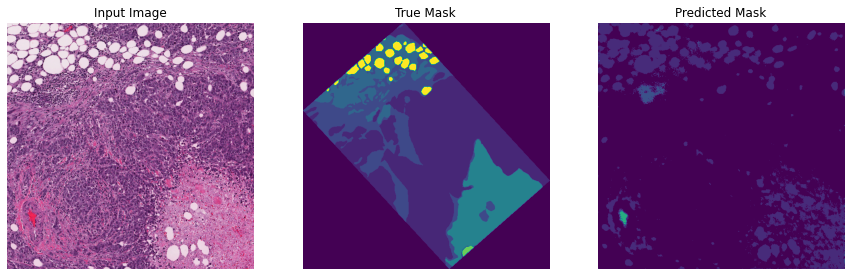

1/1 [==============================] - 0s 51ms/step


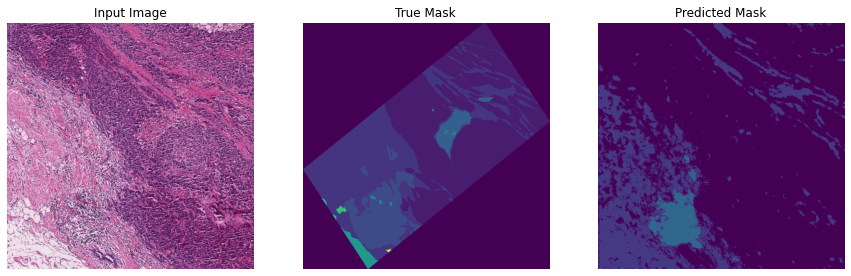

1/1 [==============================] - 0s 60ms/step


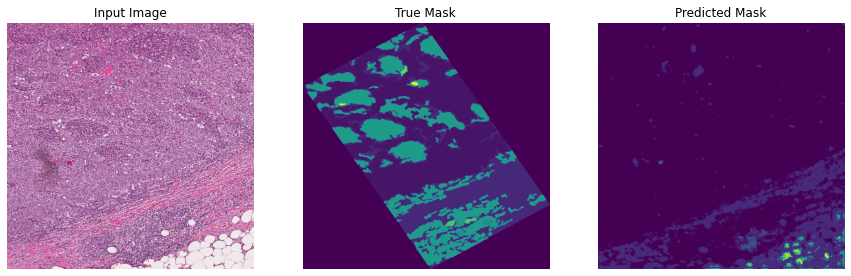

1/1 [==============================] - 0s 55ms/step


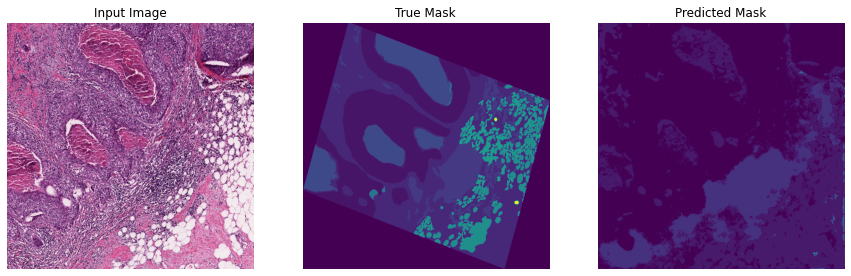

1/1 [==============================] - 0s 53ms/step


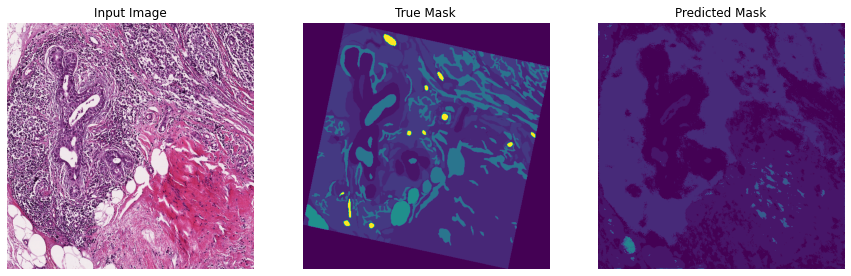

1/1 [==============================] - 0s 55ms/step


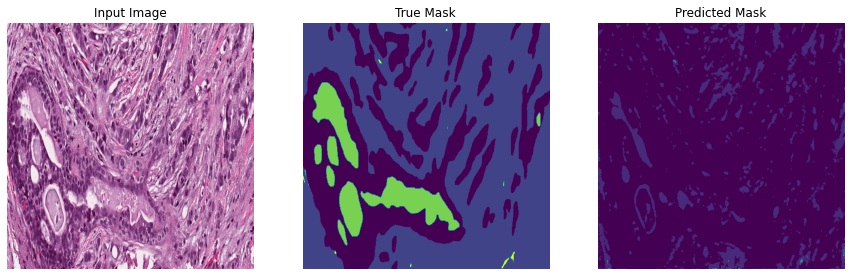

1/1 [==============================] - 0s 57ms/step


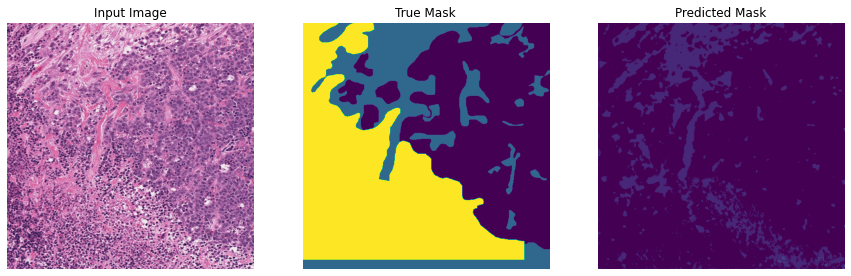

1/1 [==============================] - 0s 42ms/step


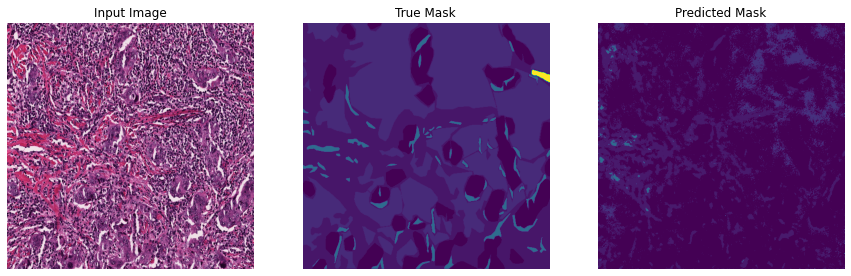

1/1 [==============================] - 0s 56ms/step


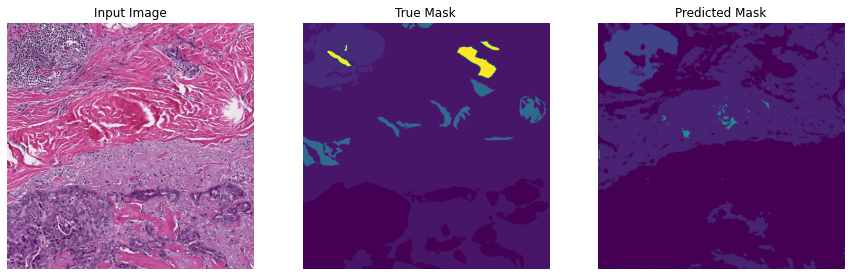

1/1 [==============================] - 0s 59ms/step


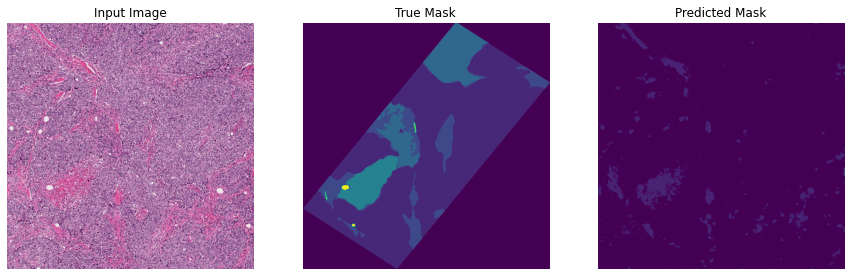

1/1 [==============================] - 0s 56ms/step


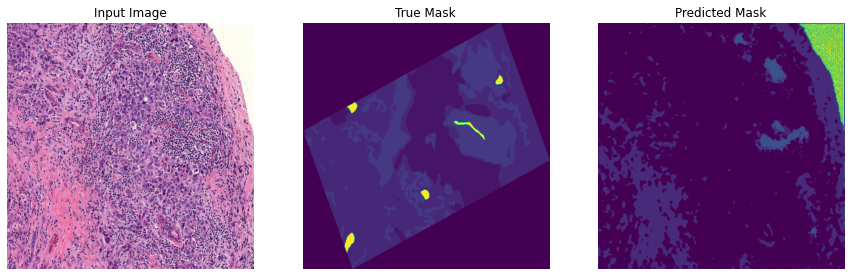

1/1 [==============================] - 0s 54ms/step


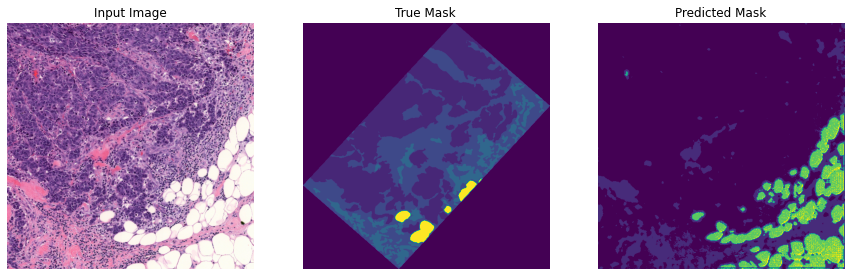

1/1 [==============================] - 0s 56ms/step


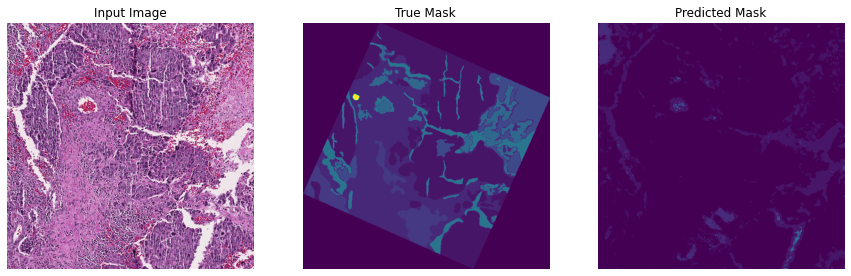

In [230]:
show_predictions(unet_model, test_ds, num=30)